In [1]:
from chromatic_fitting import *
from src.inject_spectrum import generate_spectrum_ld
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal, InverseGamma, Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup, estimate_inverse_gamma_parameters
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


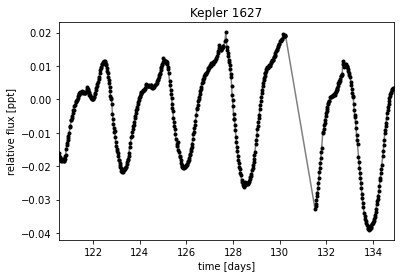

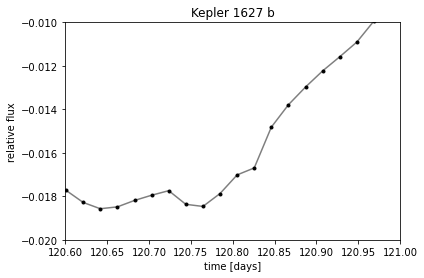

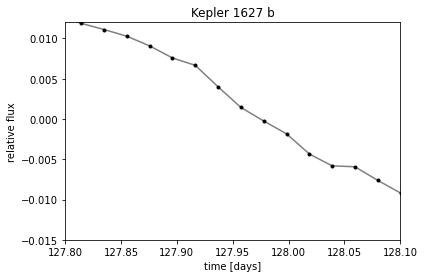

In [49]:
import lightkurve as lk
# Get long cadence light curves for all quarters. Median normalize all
# quarters, remove nans, and run a 5-sigma outlier clipping.
lcf = lk.search_lightcurve(
    "6184894", mission="Kepler", author="Kepler", cadence="long"
).download_all()
lc = lcf.stitch().remove_nans().remove_outliers()

# Require non-zero quality flags, since we have an abundance of data.
lc = lc[lc.quality == 0]
lc = lc[:600]

# Make sure that the data type is consistent
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))

# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu

# Visualize the data.
# Plot #0: full dataset
# Plot #1: a 100 day slice
# Plot #2: center it on the known Kepler ephemeris.
plt.plot(x, y, "k", alpha=0.5)
plt.plot(x, y, "k.")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("Kepler 1627")
plt.show()

# plt.plot(x, y, "k")
# plt.xlabel("time [days]")
# plt.ylabel("relative flux [ppt]")
# plt.xlim([550, 650])
# plt.title("Kepler 1627")
# plt.show()

plt.plot(x, y, "k",alpha=0.5)
plt.plot(x, y, "k.")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([120.6, 121])  # transit is here
plt.ylim([-20e-3, -10e-3])
plt.title("Kepler 1627 b")
plt.show()

plt.plot(x, y, "k",alpha=0.5)
plt.plot(x, y, "k.")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim([127.8, 128.1])  # transit is here
plt.ylim([-15e-3, 12e-3])
plt.title("Kepler 1627 b")
plt.show()

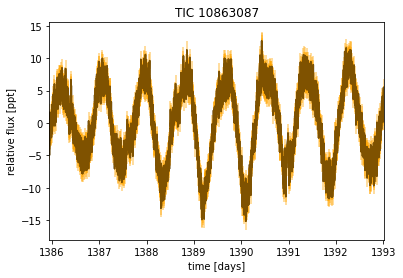

In [4]:
import lightkurve as lk

lcf = lk.search_lightcurve(
    "TIC 10863087", mission="TESS", author="SPOC"
).download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lcf.stitch().remove_nans().remove_outliers()
lc = lc[:5000]
_, mask = lc.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc = lc[~mask]

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.errorbar(x, y, yerr, color="orange", alpha=0.5)
plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087")


🌈 Warning: 
The time scale for this rainbow is '?',
and there are 600 time centers and
0 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).


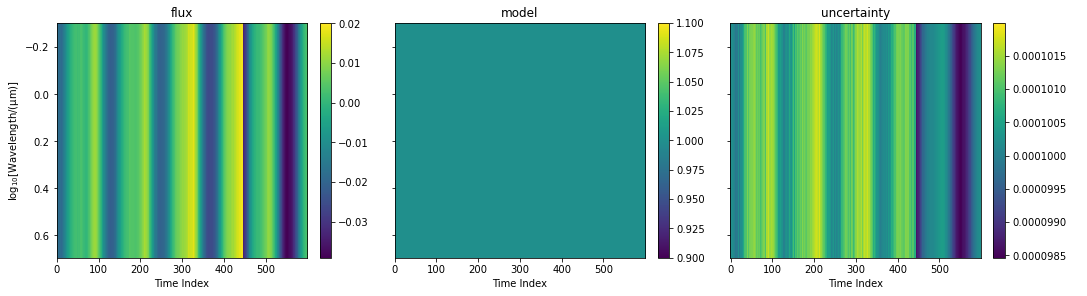

In [50]:
# s = Rainbow(dict_to_rainbow)
s = SimulatedRainbow(time=x*u.day)
s = s.bin(nwavelengths=int(s.nwave/5))#, dt=5 * u.minute)
s.fluxlike['flux'][:,:] = y
s.fluxlike['uncertainty'][:,:] = yerr
s.imshow_quantities();

In [125]:
# set up GP model:
gp_sho = SHOModel()
gp_sho.initialize_empty_model()

gp_qp = QuasiPeriodicModel()
gp_qp.initialize_empty_model()

gp_sho.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                log_sigma=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(1.0, 5.0)),
                log_rho=Fitted(InverseGamma, **estimate_inverse_gamma_parameters(0.5, 2.0)),
                Q = Fitted(Normal, mu=1.0, sigma=2.0),
                log_jitter = Fitted(Normal,mu=np.log(np.mean(s.uncertainty)),sigma=2.0),
                mean = 0.0
                )
# 1.0/np.sqrt(2.0)
# w0, the undamped angular frequency of the oscillator (w0 = 2pi / T)
# tau, the damping timescale of the process (Q = 0.5 * tau * w0)
# sigma, the standard deviation of the process, 
# A jitter term describing excess white noise

prot = 2.606418
# prot = 0.85
gp_qp.setup_parameters(
        # Rotation period is 2.6 days, from Lomb Scargle
        log_period = Fitted(Normal, mu=np.log(prot), sd=0.02),
        log_sigma=Fitted(Normal,mu=0, sd=2),#InverseGamma, **estimate_inverse_gamma_parameters(1.0, 5.0)),
#         log_sigma=Fitted(Normal,mu=np.log(2*np.std(s.flux)),sigma=2.0),
        log_Q = Fitted(Normal, mu=0, sd=2),
        log_dQ = Fitted(Normal, mu=0, sd=2),
        f = Fitted(Uniform, lower=0.01, upper=1),
        log_jitter = Fitted(Normal,mu=np.log(np.mean(s.uncertainty)),sigma=2.0),
        mean=Fitted(Normal, mu=0, sigma=1)
)
# sigma – The standard deviation of the process.
# period – The primary period of variability.
# Q0 – The quality factor (or really the quality factor minus one half; this keeps the system underdamped)
# for the secondary oscillation.
# dQ – The difference between the quality factors of the first and the second modes. 
# This parameterization (if dQ > 0) ensures that the primary mode alway has higher quality.
# f – The fractional amplitude of the secondary mode compared to the primary. 
# This should probably always be 0 < f < 1, but that is not enforced.

gp_sho.summarize_parameters()
gp_qp.summarize_parameters()

# set up transit model:
t = TransitModel()
t.initialize_empty_model()

        
t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=Fitted(Normal, mu=7.203,sigma=0.01),
                   epoch=Fitted(Normal,mu=120.79,sigma=0.002),
                   stellar_radius = Fitted(Normal, mu=0.881, sigma=0.018),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=0.9),
                   radius_ratio=Fitted(Normal, mu=0.04, sigma=0.01),
                   impact_parameter=Fitted(ImpactParameter,ror=0.0018,testval=0.57),
                   limb_darkening=Fitted(QuadLimbDark),
                   baseline = 0.0 #Fitted(Normal, mu=0, sigma=1)
                )
t.summarize_parameters()

gp_sho_log_sigma =
  <🧮 Fitted InverseGamma(alpha=8.919240823724936, beta=17.290248729724535, name='log_sigma') 🧮>

gp_sho_log_rho =
  <🧮 Fitted InverseGamma(alpha=11.830308851176651, beta=10.63134705484063, name='log_rho') 🧮>

gp_sho_Q =
  <🧮 Fitted Normal(mu=1.0, sigma=2.0, name='Q') 🧮>

gp_sho_log_jitter =
  <🧮 Fitted Normal(mu=-9.204712053899497, sigma=2.0, name='log_jitter') 🧮>

gp_sho_mean =
  <🧮 Fixed | 0.0 🧮>

gp_qp_log_sigma =
  <🧮 Fitted Normal(mu=0, sd=2, name='log_sigma') 🧮>

gp_qp_log_period =
  <🧮 Fitted Normal(mu=0.9579768649191449, sd=0.02, name='log_period') 🧮>

gp_qp_log_dQ =
  <🧮 Fitted Normal(mu=0, sd=2, name='log_dQ') 🧮>

gp_qp_log_Q =
  <🧮 Fitted Normal(mu=0, sd=2, name='log_Q') 🧮>

gp_qp_f =
  <🧮 Fitted Uniform(lower=0.01, upper=1, name='f') 🧮>

gp_qp_log_jitter =
  <🧮 Fitted Normal(mu=-9.204712053899497, sigma=2.0, name='log_jitter') 🧮>

gp_qp_mean =
  <🧮 Fixed | 0.0 🧮>

transit_stellar_radius =
  <🧮 Fitted Normal(mu=0.881, sigma=0.018, name='stellar_radius') 🧮>

In [126]:
cm = t + gp_qp
# cm = gp_sho + gp_qp

In [127]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

100%|█████████████████████████████████████████| 5/5 [00:00<00:00, 104857.60it/s]


In [128]:
# Optimize the MAP solution.

with cm.pymc3_model as pm:
    opt = pm.test_point
    print(opt)

#     name = 'gp_qp_'
#     vars_to_opt = [cm.chromatic_models['gp_qp'].parameters[f"{name}log_sigma"].get_prior(), 
#                                  cm.chromatic_models['gp_qp'].parameters[f"{name}f"].get_prior(),
#                                  cm.chromatic_models['gp_qp'].parameters[f"{name}log_period"].get_prior(),
#                                  cm.chromatic_models['gp_qp'].parameters[f"{name}log_Q"].get_prior(), 
#                                  cm.chromatic_models['gp_qp'].parameters[f"{name}log_dQ"].get_prior()]
#     opt = optimize(start=opt, vars=vars_to_opt)
    
#     name = 'transit_'
#     vars_to_opt = [cm.chromatic_models['transit'].parameters[f"{name}epoch"].get_prior(),
#                     cm.chromatic_models['transit'].parameters[f"{name}impact_parameter"].get_prior(),
#                     cm.chromatic_models['transit'].parameters[f"{name}stellar_radius"].get_prior(),
#                     cm.chromatic_models['transit'].parameters[f"{name}stellar_mass"].get_prior(),
#                     cm.chromatic_models['transit'].parameters[f"{name}limb_darkening"].get_prior(),
#                     cm.chromatic_models['transit'].parameters[f"{name}baseline"].get_prior()]
    
#     if f"{name}radius_ratio_w0" in cm.chromatic_models['transit'].parameters:
#         for i,w in enumerate(cm.data.wavelength):
#             vars_to_opt.append(cm.chromatic_models['transit'].parameters[f"{name}radius_ratio"].get_prior(i))
#     else:
#         vars_to_opt.append(cm.chromatic_models['transit'].parameters[f"{name}radius_ratio"].get_prior())
        
#     opt = optimize(start=opt,vars=vars_to_opt)
    
    opt = optimize(start=opt)

# opt = cm.optimize()
# cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
# cm.summarize(round_to=7, fmt='wide')

{'transit_period': array(7.203), 'transit_epoch': array(120.79), 'transit_impact_parameter_impact__': array(0.27767384), 'transit_stellar_radius': array(0.881), 'transit_stellar_mass_interval__': array(-1.09861229), 'transit_limb_darkening_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]), 'transit_radius_ratio': array(0.04), 'transit_baseline': array(0.), 'gp_qp_log_sigma': array(0.), 'gp_qp_log_period': array(0.95797686), 'gp_qp_log_Q': array(0.), 'gp_qp_log_dQ': array(0.), 'gp_qp_f_interval__': array(0.), 'gp_qp_log_jitter': array(-9.20471205)}


optimizing logp for variables: [gp_qp_log_jitter, gp_qp_f, gp_qp_log_dQ, gp_qp_log_Q, gp_qp_log_period, gp_qp_log_sigma, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, transit_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 8925.045054071143 -> 18414.763313279516


In [129]:
opt

{'transit_period': array(7.27660474),
 'transit_epoch': array(120.78916815),
 'transit_impact_parameter_impact__': array(-0.05193527),
 'transit_stellar_radius': array(0.87988661),
 'transit_stellar_mass_interval__': array(0.19644066),
 'transit_limb_darkening_quadlimbdark__': array([-2.60794968, -0.85253725]),
 'transit_radius_ratio': array(0.02917712),
 'transit_baseline': array(-0.00469277),
 'gp_qp_log_sigma': array(-4.47058558),
 'gp_qp_log_period': array(0.92702209),
 'gp_qp_log_Q': array(-2.92733569),
 'gp_qp_log_dQ': array(0.44883462),
 'gp_qp_f_interval__': array(-7.88914231),
 'gp_qp_log_jitter': array(-8.34820859),
 'transit_impact_parameter': array(0.48789574),
 'transit_stellar_mass': array(1.01958114),
 'transit_limb_darkening': array([0.15660643, 0.10536407]),
 'transit_model_w0': array([-0.00469277, -0.00469277, -0.00469277, -0.00469277, -0.00469277,
        -0.00469277, -0.00469277, -0.00469277, -0.00469277, -0.00469277,
        -0.00551536, -0.00557215, -0.00558765, -

In [130]:
mean: 0.04597
logg_star: 4.53116
r_star: 0.88093
period: 7.20300
t0: 120.79030
log_depth: -6.35539
b: 0.57417
log_jitter: -8.91808
log_prot: 0.96266
log_Q0: 8.90237
log_dQ: 0.00093
r_star: 0.88093
rho_star: 1.98299
depth: 0.00174
ror: 0.03981
sigma_rot: 0.99598
prot: 2.61864
f: 0.03425
r_planet: 0.34123

In [131]:
print(f"jitter is {np.exp(opt['gp_qp_log_jitter'])*1e3:.2f} ppt")
print(f"mean(yerr) is {np.mean(cm.data.uncertainty)*1e3:.2f} ppt")

jitter is 0.24 ppt
mean(yerr) is 0.10 ppt


In [132]:
ygp = opt['wavelength_0_gp_pred']+opt['transit_baseline']
ytransit = opt['transit_model_w0']-opt['transit_baseline']

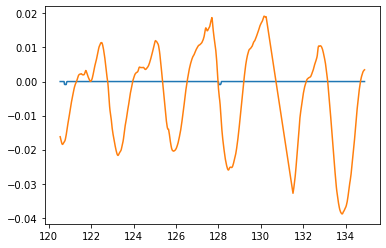

In [133]:
plt.plot(cm.data.time,ytransit)
plt.plot(cm.data.time,ygp)

In [134]:
# with cm.pymc3_model:
#     print(cm.data.flux[0, :] - eval_in_model(cm.every_light_curve['wavelength_0']))
#     plt.plot(cm.data.flux[0, :] - eval_in_model(cm.every_light_curve['wavelength_0']))
#     ytransit[0]
#     ygp = eval_in_model(cm.gp.predict(y=cm.data.flux[0, :]-ytransit[0]))
#     ypred = eval_in_model(cm.gp.predict(y=cm.data.flux[0, :]))

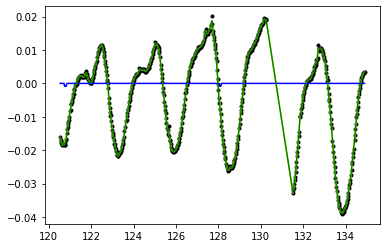

In [135]:
plt.plot(cm.data.time, cm.data.flux[0,:],'k.')
plt.plot(cm.data.time, ygp, color='yellow')
plt.plot(cm.data.time, ytransit, color='blue')
plt.plot(cm.data.time, ygp + ytransit, color='green')

In [136]:
import matplotlib as mpl
def plot_light_curve(x, y, mod, gp_mod, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=0.5,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
#     gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=41, lw=0.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp",zorder=1)
    ax.plot(x[mask], y[mask] - gp_mod, "k.")
#     for i, l in enumerate("b"):
#         mod = soln["transit_pred"][:, i]
    ax.plot(
            x[mask],
            mod,
            label="transit model (under)",
            zorder=-10,
        ) 
#    label="planet {0} [model under]".format(l),
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
#     for i, l in enumerate("b"):
#         mod = soln["transit_pred"][:, i]
    ax.plot(x[mask], y[mask] - gp_mod, "k.")
    ax.plot(x[mask], mod, label="transit model (over)") # {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

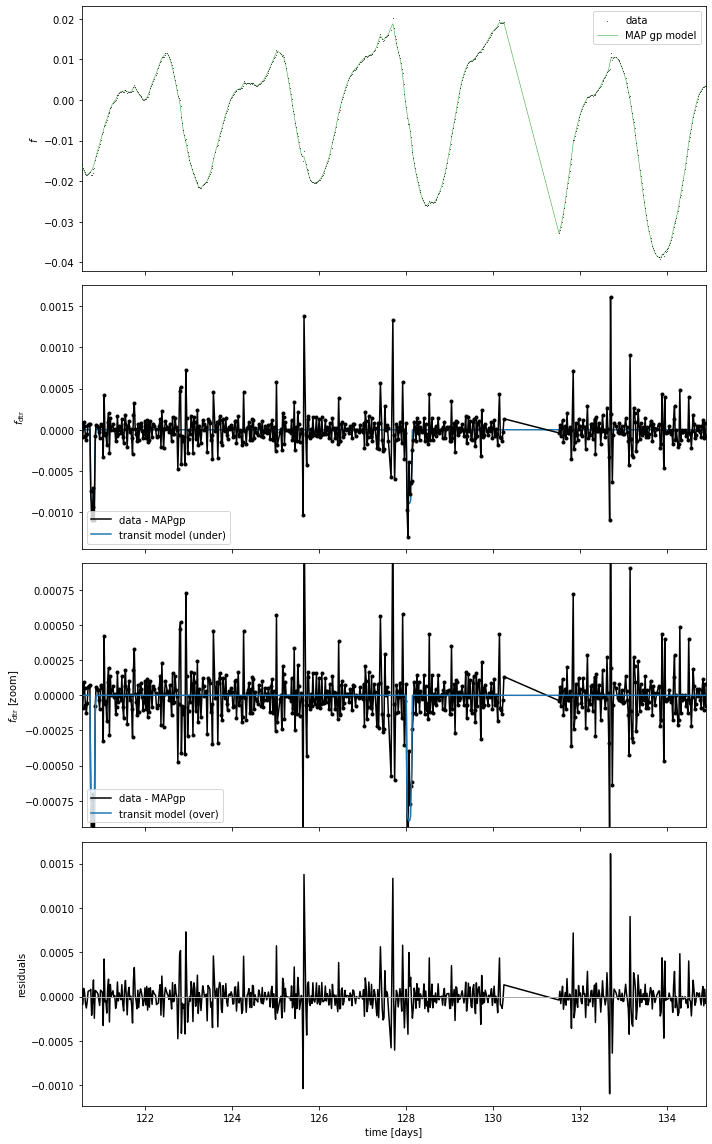

In [137]:
plot_light_curve(cm.data.time.to_value("day"), cm.data.flux[0,:], ytransit, ygp, opt)

In [138]:
cm.sample()
cm.summarize()


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gp_qp_log_jitter, gp_qp_f, gp_qp_log_dQ, gp_qp_log_Q, gp_qp_log_period, gp_qp_log_sigma, transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, transit_period]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
The number of effective samples is smaller than 25% for some parameters.


                              mean     sd   hdi_3%  hdi_97%  mcse_mean  \
transit_period               7.204  0.003    7.198    7.211        0.0   
transit_epoch              120.789  0.002  120.785  120.792        0.0   
transit_stellar_radius       0.879  0.018    0.845    0.913        0.0   
transit_radius_ratio         0.039  0.001    0.037    0.042        0.0   
transit_baseline            -0.004  0.001   -0.006   -0.003        0.0   
...                            ...    ...      ...      ...        ...   
wavelength_4_gp_pred[595]    0.007  0.001    0.006    0.008        0.0   
wavelength_4_gp_pred[596]    0.007  0.001    0.006    0.009        0.0   
wavelength_4_gp_pred[597]    0.008  0.001    0.006    0.009        0.0   
wavelength_4_gp_pred[598]    0.008  0.001    0.007    0.009        0.0   
wavelength_4_gp_pred[599]    0.008  0.001    0.007    0.009        0.0   

                           mcse_sd  ess_bulk  ess_tail  r_hat  
transit_period                 0.0    1221.0   

In [200]:
gp_model_sampled, transit_model_sampled = [], []
j, k = 0, 0
for i in cm.summary.index:
#     print(i)
    if i == f"wavelength_0_gp_pred[{j}]":
        gp_model_sampled.append(cm.summary.loc[f"wavelength_0_gp_pred[{j}]"]['mean'])
        j += 1
    if i == f"transit_model_w0[{k}]":
        transit_model_sampled.append(cm.summary.loc[f"transit_model_w0[{k}]"]['mean'])
        k += 1

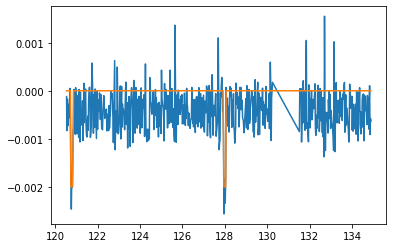

In [201]:
# gp_model_sampled
plt.plot(cm.data.time, cm.data.flux[0,:] - (gp_model_sampled+ cm.summary['mean']['transit_baseline']));
plt.plot(cm.data.time, transit_model_sampled - cm.summary['mean']['transit_baseline']);
# plt.plot(cm.data.time, cm.data.flux[0,:])
# plt.plot

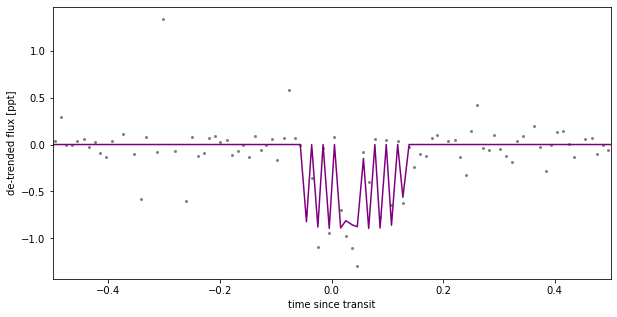

In [210]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))
x = cm.data.time.to_value("day")
y = cm.data.flux[0,:]

# Ephemeris from Holczer+16
t0 = cm.summary['mean']['transit_epoch'] #opt['transit_epoch']#120.790531
period = cm.summary['mean']['transit_period'] #opt['transit_period']#7.20280608

x_fold = (((x - t0) + (0.5 * period)) % period) - (0.5 * period)
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - ygp[m]),
    c="k",
    marker=".",
    alpha=0.5,
    linewidths=0,
)

lc_mod = ytransit
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody), c="purple", zorder=1)

# Overplot the phase binned light curve
# bins = np.linspace(-0.51, 0.51, 100)
# denom, _ = np.histogram(x_fold, bins)
# num, _ = np.histogram(x_fold, bins, weights=y - ygp)
# denom[num == 0] = 1.0
# ax.scatter(
#     0.5 * (bins[1:] + bins[:-1]),
#     1e3 * num / denom,
#     color="C1",
#     zorder=2,
#     linewidths=0,
# )

ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.17, 0.05)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

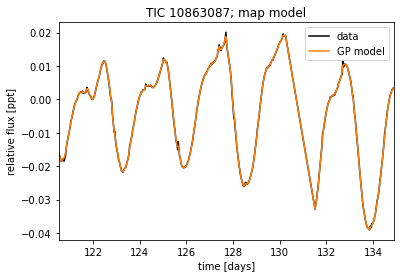

In [211]:
plt.plot(x, y, "k", label="data")
plt.plot(x, ygp, color="C1", label="GP model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("TIC 10863087; map model")

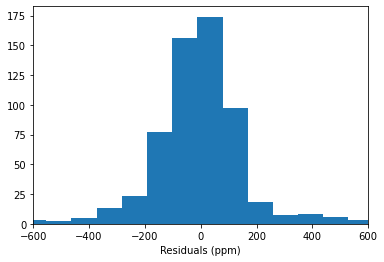

In [225]:
from scipy.stats import norm, poisson
import matplotlib.mlab as mlab

my=0
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
px = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))

ydetrend = (y - (ygp + ytransit))*1e6
# the histogram of the data
n, bins, patches = plt.hist(ydetrend,30)
plt.xlabel("Residuals (ppm)")
plt.xlim(-600,600)

plt.plot(px, poisson.pmf(px, mu), 'bo', ms=8, label='poisson pmf')

In [223]:
px

array([], dtype=float64)

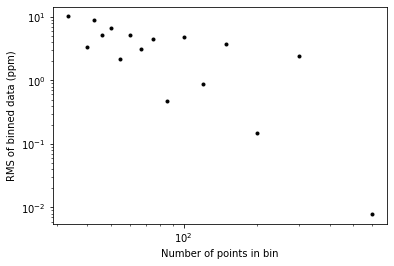

In [197]:
def rmsValue(arr):
    n = len(arr)
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = (square / n)
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root


from scipy.stats import binned_statistic

x, y = [], []
for i in range(1,601):
    ret = binned_statistic(cm.data.time, ydetrend, statistic='mean', bins=i)
    ret_count = binned_statistic(cm.data.time, ydetrend, statistic='count', bins=i)
    y.append(np.sqrt(np.sum(ret.statistic**2)/len(ret.statistic)))
    x.append(np.nanmean(ret_count.statistic))

offset = y[-1]
    
xmodel = np.linspace(1,601)
plt.loglog(x, y,'k.');
plt.ylabel("RMS of binned data (ppm)")
plt.xlabel("Number of points in bin")
plt.loglog(xmodel, offset * (1/np.sqrt(xmodel)));

In [186]:
len(cm.data.time)

600